In [34]:
import sys
!{sys.executable} -m pip install nltk bs4

import string
import json
from collections import Counter, defaultdict
import itertools

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

%matplotlib inline

# NOTE: utils is a python package created by me to store helper functions and make notebook more readable and understandable
from utils import process_json_batches, standardize, parse_course_raw_html

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rpartsey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rpartsey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rpartsey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **[Stack Overflow](https://stackoverflow.com/) part**

## **[DOU](https://dou.ua/) part**

## **[LinkedIn](https://www.linkedin.com) part**

## **[Coursera](https://www.coursera.org/) part**

#### How have I collected courses data?
I investigated browser network while searching for Data Science courses and found specific request responsible for getting courses data from the server.
Each response contained batch of 30 courses, their short description and metadata. Manually I filtered these requests and stored data in the JSON formatted file (`data/beautified_data.json`). As a result I got 15 batches with 437 courses. The code in the cell below reads file with data, processes it and stores in the pandas.DataFrame.
<br>
<br>
<img src="./images/coursera_courses_page.png" />



In [3]:
# #raw courses json data processing

# data_file = 'data/beautified_data.json'

# batches = []
# with open(data_file) as f:
#     batches_dict = json.load(f)  # key = "batch<id: int>", value = list(courses)   
#     courses_list = list(process_json_batches(batches_dict.values()))
    
# print(f'Number of loaded courses: {len(courses_list)}')

# courses_df = pd.DataFrame(courses_list)
# courses_df.head()

**Note:** I execuded the code above and stored the result in the `data/coursera_courses.json` file, so instead of executing it again you may just read the file:

In [4]:
courses_general_data_df = pd.read_json('data/coursera_courses.json')
courses_general_data_df.head()

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills,course_id,course_level,course_name,course_slug,course_workload,partners
0,4.9,56.0,28407.0,115691.0,"[{'relevanceScore': 1.7358247226999999, 'skill...",Gtv4Xb1-EeS-ViIACwYKVQ,None,Machine Learning,machine-learning,,[{'partner_name': 'Stanford University'}]
1,4.9,18.0,11607.0,61224.0,"[{'relevanceScore': 1.5504907103, 'skillName':...",W_mOXCrdEeeNPQ68_4aPpA,INTERMEDIATE,Neural Networks and Deep Learning,neural-networks-deep-learning,,[{'partner_name': 'deeplearning.ai'}]
2,4.7,6.0,2667.0,16698.0,"[{'relevanceScore': 1.4273084427, 'skillName':...",r0GnHOZaEees-Q6jQMxlrg,BEGINNER,What is Data Science?,what-is-datascience,"3 weeks of study, 2-3 hours/week",[{'partner_name': 'IBM'}]
3,4.5,18.0,2855.0,12317.0,"[{'relevanceScore': 1.6255460667000001, 'skill...",RZ1S0B0MEeacvQ6cODzg5Q,INTERMEDIATE,Introduction to Data Science in Python,python-data-analysis,,[{'partner_name': 'University of Michigan'}]
4,4.9,21.0,3033.0,25227.0,"[{'relevanceScore': 1.6032385046000002, 'skill...",kWGvJivBEeeW5RJUyz1uFA,INTERMEDIATE,Convolutional Neural Networks,convolutional-neural-networks,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'deeplearning.ai'}]



Let's take a look at skills frequencies to gain better unerstanding

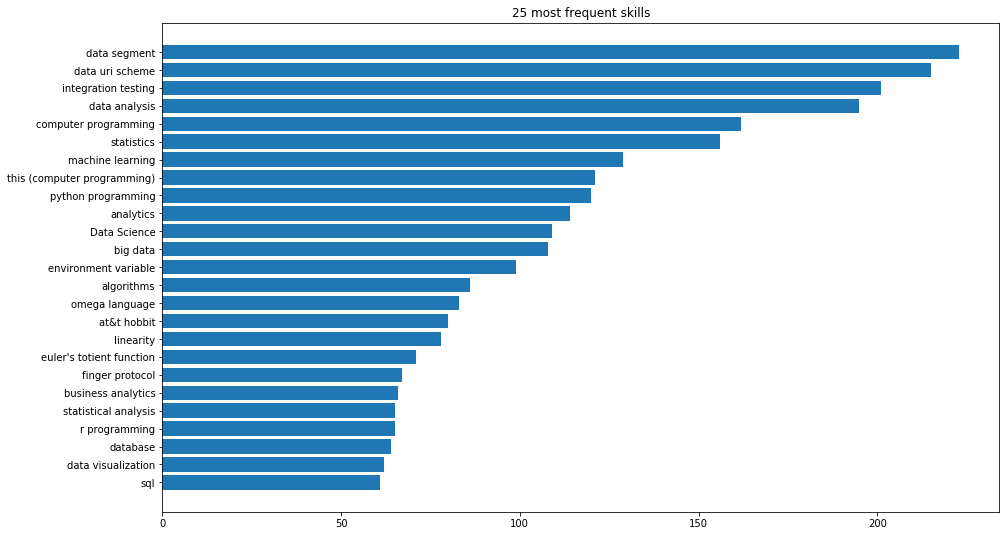

In [5]:
# show skills occurrences
n = 25
skills_counter = Counter(itertools.chain(*courses_general_data_df.skills.map(lambda skills: (s['skillName'] for s in skills))))

most_common_skills = dict(skills_counter.most_common(n)[::-1]) # need to reverse here to plot bars in decreasing order

fig = plt.figure(figsize=(15,9))
plt.barh(list(most_common_skills.keys()), list(most_common_skills.values()))
plt.title(f'{n} most frequent skills')
plt.show()

Let's also check least common skills. And as far as, their frequencies are usually equal to 1, we will just print them

In [6]:
skills_counter.most_common()[:-n-1:-1]       # n least common elements

[('context-free grammar', 1),
 ('google hangouts', 1),
 ('fingerprints', 1),
 ('axosoft', 1),
 ('google wallet', 1),
 ('one month', 1),
 ('language industry', 1),
 ('ml (programming language)', 1),
 ('vest', 1),
 ('entropy (information theory)', 1),
 ('uniform resource identifier', 1),
 ('grayed out', 1),
 ('run time (program lifecycle phase)', 1),
 ('page table', 1),
 ('connect:direct', 1),
 ('list of facebook features', 1),
 ('recordset', 1),
 ('japanese language', 1),
 ('data feed', 1),
 ('spectrum reallocation', 1),
 ('race condition', 1),
 ('crossbridge', 1),
 ('petabyte', 1),
 ('boyer moore string search algorithm', 1),
 ('directaccess', 1)]

## **Experiments with [Coursera](https://www.coursera.org/) data**
#### What's the goal?
The idea is to try to apply clustering algorithms to group courses into clusters that potentially may be used as subjects in the university curriculum, using only available Coursera data. <br> We want to check if it's enough to use just courses data to build a curriculums.

#### Data Science program curriculum design experiment

In [7]:
# filter courses with skills only(some courses have empty list of skills)
courses_with_skills_df = courses_general_data_df[courses_general_data_df.skills.map(lambda value: len(value)) > 0].reset_index(drop=True)
courses_with_skills_df.head()

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills,course_id,course_level,course_name,course_slug,course_workload,partners
0,4.9,56.0,28407.0,115691.0,"[{'relevanceScore': 1.7358247226999999, 'skill...",Gtv4Xb1-EeS-ViIACwYKVQ,None,Machine Learning,machine-learning,,[{'partner_name': 'Stanford University'}]
1,4.9,18.0,11607.0,61224.0,"[{'relevanceScore': 1.5504907103, 'skillName':...",W_mOXCrdEeeNPQ68_4aPpA,INTERMEDIATE,Neural Networks and Deep Learning,neural-networks-deep-learning,,[{'partner_name': 'deeplearning.ai'}]
2,4.7,6.0,2667.0,16698.0,"[{'relevanceScore': 1.4273084427, 'skillName':...",r0GnHOZaEees-Q6jQMxlrg,BEGINNER,What is Data Science?,what-is-datascience,"3 weeks of study, 2-3 hours/week",[{'partner_name': 'IBM'}]
3,4.5,18.0,2855.0,12317.0,"[{'relevanceScore': 1.6255460667000001, 'skill...",RZ1S0B0MEeacvQ6cODzg5Q,INTERMEDIATE,Introduction to Data Science in Python,python-data-analysis,,[{'partner_name': 'University of Michigan'}]
4,4.9,21.0,3033.0,25227.0,"[{'relevanceScore': 1.6032385046000002, 'skill...",kWGvJivBEeeW5RJUyz1uFA,INTERMEDIATE,Convolutional Neural Networks,convolutional-neural-networks,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'deeplearning.ai'}]


Each course has list with skills it provides and their relevance score (numerical value representing relevance of specific skill in the course). We will use this valuse as features.

In [8]:
courses_with_skills_df.loc[0, 'skills'][:5]

[{'relevanceScore': 1.7358247226999999, 'skillName': 'machine learning'},
 {'relevanceScore': 1.2675839176, 'skillName': 'algorithms'},
 {'relevanceScore': 1.2402567261, 'skillName': 'artificial neural network'},
 {'relevanceScore': 1.2100148486, 'skillName': 'machine learning algorithms'},
 {'relevanceScore': 1.1922643639000001, 'skillName': 'linearity'}]

In [9]:
# define empty matrix, rows represent courses, columns - skills they provide
X = np.zeros(shape=(courses_with_skills_df.shape[0], len(skills_counter.keys())))
X.shape

(413, 3601)

In [10]:
# fill the matrix with skills relevance scores
for i, course in courses_with_skills_df.iterrows():
    for j, skill in enumerate(skills_counter):
        for course_skill in course.skills:
            if course_skill['skillName'] == skill:
                X[i,j] = course_skill['relevanceScore'] 

Among all clustering algorithms I've found `KMeans` with `n_clusters=25` giving the best results.

In [11]:
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=25, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
for i in range(1, n_clusters):
    print(sum(kmeans.labels_ == i))
    print(courses_with_skills_df[kmeans.labels_ == i].course_name)
    print()
    print()

14
2                                 What is Data Science? 
15                    Open Source tools for Data Science
44                              Introduction to Big Data
72     Big Data Essentials: HDFS, MapReduce and Spark...
97             Hadoop Platform and Application Framework
100                Fundamentals of Scalable Data Science
104                       Machine Learning With Big Data
128             Big Data Modeling and Management Systems
151    Data Warehouse Concepts, Design, and Data Inte...
163                  Big Data Integration and Processing
185                Spatial Data Science and Applications
207    Data Manipulation at Scale: Systems and Algori...
300      Relational Database Support for Data Warehouses
327                          Big Data - Capstone Project
Name: course_name, dtype: object


199
17             Getting Started with AWS Machine Learning
29          Introduction to Artificial Intelligence (AI)
36                Fundamentals of Reinforcemen

Of course, dimensionality reduction of highdimensional data to 2 dimensions doesn't preserve its real distribution, but at least we may try to check how clusters are approximately located.

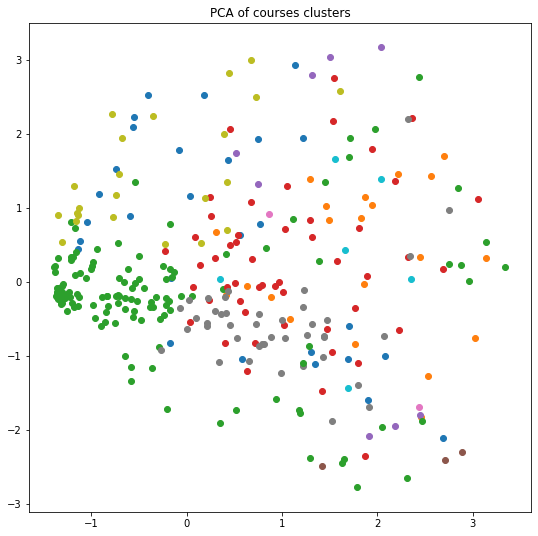

In [13]:
X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(9,9))
for i in range(0,n_clusters):
    plt.scatter(X_pca[ kmeans.labels_==i, 0],X_pca[kmeans.labels_==i,1])
plt.title('PCA of courses clusters')
plt.show()


#### Course curriculum design experiment
Let's now filter courses that contain "Data science" and view skill they provide. We may think of this skills as must-teach skill for "Intoduction to data science" course.

In [14]:
courses_with_ds_skills_df = courses_with_skills_df[courses_with_skills_df.course_name.map(lambda value: 'data science' in value.lower())].reset_index(drop=True)
ds_skills_counter = Counter(itertools.chain(*courses_with_ds_skills_df.skills.map(lambda skills: (s['skillName'] for s in skills))))
ds_skills_counter.most_common(25)

[('Data Science', 36),
 ('data segment', 30),
 ('data uri scheme', 30),
 ('data analysis', 30),
 ('computer programming', 23),
 ('integration testing', 22),
 ('statistics', 21),
 ('machine learning', 18),
 ('python programming', 18),
 ('finger protocol', 16),
 ('big data', 15),
 ('r programming', 14),
 ('analytics', 12),
 ('this (computer programming)', 11),
 ('artificial intelligence', 11),
 ('sql', 11),
 ('exploratory data analysis', 11),
 ('data mining', 10),
 ('data model', 10),
 ('database', 10),
 ('ipython', 9),
 ('algorithms', 9),
 ('omega language', 9),
 ('environment variable', 9),
 ('analysis', 9)]

#### Experiments summary
Even though we got some meaningful clusters: Data Visualization, R Programming, Database Management, Statistics ... for the Data Science program curriculum design experiment. Some of them contain different courses that souldn't be placed in the same cluster. So it's not enough to take into account just courses and their skills to predict curriculum.
<br>
<br>Also most common skills taught in coursera "Data Science" courses do not convey a lot of information about how course should be structured and which specific topics to include.
<br>
<br>So our next idea is integratation with job postings.

## **Integration with job postings**
#### Big picture view
<img src="./images/program_flow.png" />

**Note:** currently we support only [LinkedIn]() and [Coursera](https://www.coursera.org/) :)

#### Does this dataframe contain enough information for analysis?

Now we have the dataframe with general courses information, but it's necessary to take into account their description and syllabus as well. Why? Because skills list found in the coursera get request response usually contains a lot of noise(words that actually aren't skills).

#### Fetching course html

In the examples above we were using skills from the course skills list, found in the get request response.
But we can use couse description and syllabus to look for another skill as well.
In the code cell below we will scrape course details page using `parse_course_raw_html` function from `utils`package.
<br>
Code below stores courses descriptions into the `coursera_courses_descriptions.json` file.

In [15]:
# # fetching the course description data

# course_description_map = {
#     'course_slug': [],
#     'course_description': []
# }

# for i, course in courses_general_data_df.iterrows():
#     print(i, course['course_slug']) # print each iteration to see a progress
#     response = requests.get(f'https://www.coursera.org/learn/{course["course_slug"]}')
    
#     soup = BeautifulSoup(response.text)
#     course_description = parse_course_raw_html(soup)
    
#     course_description_map['course_slug'].append(course['course_slug'])
#     course_description_map['course_description'].append(course_description)

# # assert len(course_description_map) == courses_df.shape[0], 'Not all courses html pages were fetched!'

# with open('coursera_courses_descriptions.json', 'w+') as f:
#     json.dump(course_description_map, f)

**Note:** Courses descriptions are already stored in the `data/coursera_courses_descriptions.json` file. Let's check it out.

In [16]:
courses_descriptions_df = pd.read_json('data/coursera_courses_descriptions.json')
courses_descriptions_df.head()

,course_slug,course_description
0,machine-learning,Machine learning is the science of getting com...
1,neural-networks-deep-learning,"If you want to break into cutting-edge AI, thi..."
2,what-is-datascience,The art of uncovering the insights and trends ...
3,python-data-analysis,This course will introduce the learner to the ...
4,convolutional-neural-networks,This course will teach you how to build convol...


Let's merge two dataframes into one.

In [17]:
courses_df = pd.merge(courses_general_data_df, courses_descriptions_df, on='course_slug')
courses_df.head()

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills,course_id,course_level,course_name,course_slug,course_workload,partners,course_description
0,4.9,56.0,28407.0,115691.0,"[{'relevanceScore': 1.7358247226999999, 'skill...",Gtv4Xb1-EeS-ViIACwYKVQ,None,Machine Learning,machine-learning,,[{'partner_name': 'Stanford University'}],Machine learning is the science of getting com...
1,4.9,18.0,11607.0,61224.0,"[{'relevanceScore': 1.5504907103, 'skillName':...",W_mOXCrdEeeNPQ68_4aPpA,INTERMEDIATE,Neural Networks and Deep Learning,neural-networks-deep-learning,,[{'partner_name': 'deeplearning.ai'}],"If you want to break into cutting-edge AI, thi..."
2,4.7,6.0,2667.0,16698.0,"[{'relevanceScore': 1.4273084427, 'skillName':...",r0GnHOZaEees-Q6jQMxlrg,BEGINNER,What is Data Science?,what-is-datascience,"3 weeks of study, 2-3 hours/week",[{'partner_name': 'IBM'}],The art of uncovering the insights and trends ...
3,4.5,18.0,2855.0,12317.0,"[{'relevanceScore': 1.6255460667000001, 'skill...",RZ1S0B0MEeacvQ6cODzg5Q,INTERMEDIATE,Introduction to Data Science in Python,python-data-analysis,,[{'partner_name': 'University of Michigan'}],This course will introduce the learner to the ...
4,4.9,21.0,3033.0,25227.0,"[{'relevanceScore': 1.6032385046000002, 'skill...",kWGvJivBEeeW5RJUyz1uFA,INTERMEDIATE,Convolutional Neural Networks,convolutional-neural-networks,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'deeplearning.ai'}],This course will teach you how to build convol...


Let's now convert descriptions to lowercase and replace all punctuation marks and any other symbols with whitespaces using `standardize` function from `utils`package.

In [18]:
# helper function
def standardize_text(text):
    punctuation = string.punctuation
    strange_symbols = ['•', '—', "\n", " ", "\t", "●", "🔸", "nan", "﻿"]
    tokenize_f = tokenize.word_tokenize
    lemmatizer = WordNetLemmatizer() 
    lemmatize_f = lemmatizer.lemmatize
    stop_words = set(stopwords.words('english'))
    
    return standardize(text, punctuation, strange_symbols, 
                       tokenize_f=tokenize_f, lemmatize_f=lemmatize_f, 
                       stop_words=stop_words, replace_symbol=' ')


courses_df['standardized_description'] = ''
for i, course in courses_df.iterrows():
    course_skills = (s['skillName'] for s in course.skills)
    text = '.'.join([*course_skills, course.course_description]) # NOTE: we add course skills to it's description and syllabus 
    
    courses_df.loc[i,'standardized_description'] = standardize_text(text)

# courses_df.loc[4, 'description']

We used list of [Linkedin](https://www.linkedin.com) [skills](https://gist.githubusercontent.com/bragboy/89777a2eacb8ca46d2c13e44bf928b7e/raw/08ea8211f833f0bb75b377c2827ea9b76ed4b814/all_linked_skills.txt) found on the Internet wep [page](http://tech.bragboy.com/2016/11/crawl-all-linkedin-skills.html) as the "list of all possible skills".

In [19]:
with open('data/all_linked_skills.txt', 'r') as f:
    skills_dict = dict.fromkeys((standardize_text(s) for s in f.read().split('\n')), 0)

In [20]:
# # compute how frequently skills appear in course descriptions
# for skill in skills_dict:
#     for description in courses_df.standardized_description:
#         if f' {skill} ' in f' {description} ':
#             skills_dict[skill] += 1 

In [21]:
# # sort skills by frequencies and restructure dict to create dataftame

# skills = list(skills_dict.items())
# skills.sort(key=lambda t: t[1], reverse=True)
# skills

# d = {
#     'skill': [],
#     'count': []
# }

# for s, c in skills:
#     if c > 0:
#         d['skill'].append(s),
#         d['count'].append(c)
        
# pd.DataFrame(d)#.to_csv('clean_courses_skills.csv')

And then for each course and for each skill from "list of all possible skills" we loork for skills that appear in the course description.

In [22]:
course_computed_skills = defaultdict(set) # key = "course_slug", value = list(skills)

for _, (course_slug, description)  in courses_df[['course_slug', 'standardized_description']].iterrows():
    for skill in skills_dict:
        if f' {skill} ' in f' {description} ':
            course_computed_skills[course_slug].add(skill)

d = {
    'course_slug': [],
    'computed_skills': []
}

for c, s in course_computed_skills.items():
    d['course_slug'].append(c)
    d['computed_skills'].append(s)
        
courses_skills_df = pd.DataFrame(d) #.to_csv('clean_courses_skills.csv')
# courses_skills_df.loc[0,'computed_skills']

Also for each skill from "list of all possible skills" we computed how frequently it appears in [LinkedIn](https://www.linkedin.com) job postings.
We stored the result in `data/filtered_vacancies_skills.csv` file.

In [23]:
job_skills_df = pd.read_csv('data/filtered_vacancies_skills.csv')
job_skills_df.head()
# job_skills_df['count'] = np.sqrt(job_skills_df['count'])*10

,Unnamed: 0,skill,count
0,10900,data,3348
1,15594,experience,3193
2,48758,work,2785
3,43922,team,2735
4,20913,skill,0


Compute score for each course, based on skills it provides.

In [24]:
courses_rating_dict = {} # key = "course_slug", value = list(skills)
skills_map = {skill:count for _, (skill, count) in job_skills_df[['skill', 'count']].iterrows()}

for _, (course_slug, skills_list) in courses_skills_df.iterrows():
    for skill in skills_list :
        if skill in skills_map:
            if course_slug in courses_rating_dict:
                courses_rating_dict[course_slug]['count'] += skills_map[skill]
                courses_rating_dict[course_slug]['skills'].append((skill, skills_map[skill]))
            else:
                courses_rating_dict[course_slug] = {
                    'count': skills_map[skill],
                    'skills':[(skill, skills_map[skill])]
                }


len(courses_rating_dict)
# courses_rating_dict

437

In [25]:
# create a dataframe from courses_rating_dict
d = {
    'course_slug': [],
    'scores': [],
    'skills': []
}

for k, v in courses_rating_dict.items():
    d['course_slug'].append(k)
    d['scores'].append(v['count'])
    d['skills'].append(sorted(v['skills'], key=lambda t: t[1], reverse=True))
    
        
course_scores_df = pd.DataFrame(d)
course_scores_df.sort_values(by=['scores'], ascending=False, inplace=True)
# course_scores_df.to_csv('courses_scores_with_weights.csv') 

In [26]:
# drop courses without rating and reviews data
courses_df = courses_df[np.logical_not(np.logical_or(courses_df.ratingCount.isnull(), courses_df.averageFiveStarRating.isnull()))]
courses_df.head()

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills,course_id,course_level,course_name,course_slug,course_workload,partners,course_description,standardized_description
0,4.9,56.0,28407.0,115691.0,"[{'relevanceScore': 1.7358247226999999, 'skill...",Gtv4Xb1-EeS-ViIACwYKVQ,None,Machine Learning,machine-learning,,[{'partner_name': 'Stanford University'}],Machine learning is the science of getting com...,machine learning algorithm artificial neural n...
1,4.9,18.0,11607.0,61224.0,"[{'relevanceScore': 1.5504907103, 'skillName':...",W_mOXCrdEeeNPQ68_4aPpA,INTERMEDIATE,Neural Networks and Deep Learning,neural-networks-deep-learning,,[{'partner_name': 'deeplearning.ai'}],"If you want to break into cutting-edge AI, thi...",deep learning artificial neural network python...
2,4.7,6.0,2667.0,16698.0,"[{'relevanceScore': 1.4273084427, 'skillName':...",r0GnHOZaEees-Q6jQMxlrg,BEGINNER,What is Data Science?,what-is-datascience,"3 weeks of study, 2-3 hours/week",[{'partner_name': 'IBM'}],The art of uncovering the insights and trends ...,data science data segment data mining data uri...
3,4.5,18.0,2855.0,12317.0,"[{'relevanceScore': 1.6255460667000001, 'skill...",RZ1S0B0MEeacvQ6cODzg5Q,INTERMEDIATE,Introduction to Data Science in Python,python-data-analysis,,[{'partner_name': 'University of Michigan'}],This course will introduce the learner to the ...,panda python programming computer programming ...
4,4.9,21.0,3033.0,25227.0,"[{'relevanceScore': 1.6032385046000002, 'skill...",kWGvJivBEeeW5RJUyz1uFA,INTERMEDIATE,Convolutional Neural Networks,convolutional-neural-networks,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'deeplearning.ai'}],This course will teach you how to build convol...,convolutional neural network artificial neural...


We want course rating to have an impact on predicted courses as well(if the courses have very close scores, we prefer ones with higher `averageFiveStarRating`). <br>
We calculate weighted rating for `averageFiveStarRating` field using  [WR](https://stats.stackexchange.com/questions/6418/rating-system-taking-account-of-number-of-votes) formula.

In [27]:
# compute weighted rating for averageFiveStarRating field
def weighted_rating(R, v, m, C):
    return (v / (v + m)) * R + (m / (v + m)*C)

R =  courses_df['averageFiveStarRating']
v =  courses_df['ratingCount']
m =  50
C = courses_df['averageFiveStarRating'].mean()

courses_df['WR'] = weighted_rating(R, v, m, C)

## **Our results:**
#### **Courses with skills that appear in most [LinkedIn](https://www.linkedin.com) vacancies ordered by scores(the higher score the better course)**


In [28]:
# merge courses with corresponding scores and multiply score by weighted rating
courses_with_scores_df = pd.merge(courses_df, course_scores_df, on='course_slug')
courses_with_scores_df['scores'] = courses_with_scores_df['scores'] * courses_with_scores_df['WR'] 
courses_with_scores_df.sort_values(by=['scores'], ascending=False, inplace=True)
courses_with_scores_df.reset_index(drop=True, inplace=True)

# display courses info: name, score, skills that contributed to its score, and its coursera link that can be pasted into browser to see detailed information
courses_with_scores_df['course_link'] = 'https://www.coursera.org/learn/' + courses_with_scores_df['course_slug']
courses_with_scores_df[['course_name','scores', 'skills_y', 'course_link']].head(20)

,course_name,scores,skills_y,course_link
0,Data Visualization and Communication with Tableau,439513.499620,"[(data, 3348), (work, 2785), (business, 2481),...",https://www.coursera.org/learn/analytics-tableau
1,Process Mining: Data science in Action,399708.684335,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/process-mining
2,How to Win a Data Science Competition: Learn f...,392192.141809,"[(data, 3348), (experience, 3193), (work, 2785...",https://www.coursera.org/learn/competitive-dat...
3,Spatial Data Science and Applications,391092.649660,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/spatial-data-sc...
4,Business Analytics Capstone,381759.622983,"[(data, 3348), (experience, 3193), (work, 2785...",https://www.coursera.org/learn/wharton-capston...
5,Business Analytics Executive Overview,381463.643032,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/business-analyt...
6,Machine Learning Foundations: A Case Study App...,379690.927198,"[(data, 3348), (experience, 3193), (business, ...",https://www.coursera.org/learn/ml-foundations
7,Managing Big Data with MySQL,377263.196130,"[(data, 3348), (work, 2785), (business, 2481),...",https://www.coursera.org/learn/analytics-mysql
8,Introduction to Accounting Data Analytics and ...,376792.755645,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/intro-accountin...
9,Big Data Modeling and Management Systems,374169.094404,"[(data, 3348), (experience, 3193), (work, 2785...",https://www.coursera.org/learn/big-data-manage...


In [29]:
courses_with_scores_df.loc[0,'course_link']

'https://www.coursera.org/learn/analytics-tableau'

#### **Conclusion:**
The above list can be used to design a program curriculum that will cover skills appearing in most [LinkedIn](https://www.linkedin.com) job postings. <br>
As a result, the more required skills you have, the higher your chances to be hired. 

#### **Courses that have "Data Science" in titles and with skills that appear in most [LinkedIn](https://www.linkedin.com) vacancies**


In [30]:
ds_courses = courses_with_scores_df[courses_with_scores_df.course_name.map(lambda value: 'data science' in value.lower())]
ds_courses.reset_index(drop=True, inplace=True)
ds_courses[['course_name', 'scores', 'skills_y', 'course_link']].head(20)

,course_name,scores,skills_y,course_link
0,Process Mining: Data science in Action,399708.684335,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/process-mining
1,How to Win a Data Science Competition: Learn f...,392192.141809,"[(data, 3348), (experience, 3193), (work, 2785...",https://www.coursera.org/learn/competitive-dat...
2,Spatial Data Science and Applications,391092.649660,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/spatial-data-sc...
3,Data Science Ethics,360263.992823,"[(data, 3348), (work, 2785), (business, 2481),...",https://www.coursera.org/learn/data-science-et...
4,SQL for Data Science,343355.486903,"[(data, 3348), (work, 2785), (business, 2481),...",https://www.coursera.org/learn/sql-for-data-sc...
5,Communicating Data Science Results,330214.797099,"[(data, 3348), (experience, 3193), (business, ...",https://www.coursera.org/learn/data-results
6,What is Data Science?,328682.575412,"[(data, 3348), (work, 2785), (business, 2481),...",https://www.coursera.org/learn/what-is-datasci...
7,A Crash Course in Data Science,311880.541548,"[(data, 3348), (team, 2735), (science, 2323), ...",https://www.coursera.org/learn/data-science-co...
8,Applied Data Science Capstone,308721.452939,"[(data, 3348), (work, 2785), (science, 2323), ...",https://www.coursera.org/learn/applied-data-sc...
9,Databases and SQL for Data Science,307592.413714,"[(data, 3348), (work, 2785), (science, 2323), ...",https://www.coursera.org/learn/sql-data-science


#### **Conclusion:**
Yes, this is not the list of the subject to cover in "Introduction to Data Science", but again it contains a lot of useful information:
1. this is the ordered list of Data Science courses that cover most demanding skills from job postings
2. courses syllabuses and descriptions may be very useful for designing university Data Science course curriculum

## **One more experiment :)**
All our previous experiments were "gready", we tried to build a rating for courses that cover the most demanding skills. So the more demanding skills course covers the better. <br>
Here we tried to take a wider view and idea is following: if we already covered a skill in the previous course, then we decrease its value/rating dividing it by 2. 
<br> So the next time it is met in the new course skills list, it contributes only half of its previous value to course rating.

In [31]:
num_courses = 20

coursesToStudy = []
courseToRating = {}

for _, (course_slug, wr) in courses_with_scores_df[['course_slug', 'WR']].iterrows():
    courseToRating[course_slug] = wr

skills_map = {skill:count for _, (skill, count) in job_skills_df[['skill', 'count']].iterrows()}
for i in range(num_courses):
    courses_rating_dict = {} # key = "course_slug", value = list(skills)

    for _, (course_slug, skills_list) in courses_skills_df.iterrows():
        for skill in skills_list :
            if skill in skills_map:
                if course_slug in courses_rating_dict:
                    courses_rating_dict[course_slug]['count'] += skills_map[skill] * courseToRating.get(course_slug, 0)
                    courses_rating_dict[course_slug]['skills'].append((skill, skills_map[skill]))
                else:
                    courses_rating_dict[course_slug] = {
                        'count':skills_map[skill]*courseToRating.get(course_slug, 0),
                        'skills':[(skill, skills_map[skill])]
                    }
    maxCount = 0
    courseWithMax = {}
    for course_slug in courses_rating_dict:
        if courses_rating_dict[course_slug]['count'] > maxCount:
            courseWithMax = course_slug
            maxCount = courses_rating_dict[course_slug]['count']
    coursesToStudy.append(courseWithMax)
    
    for skillTuple in courses_rating_dict[courseWithMax]['skills']:
        skills_map[skillTuple[0]] /= 2
    
    
coursesToStudy

['analytics-tableau',
 'competitive-data-science',
 'wharton-capstone-analytics',
 'spatial-data-science',
 'process-mining',
 'business-intelligence-tools',
 'deep-learning-business',
 'healthcare-data-quality-governance',
 'ml-regression',
 'nursing-informatics-leaders',
 'data-manipulation',
 'global-statistics',
 'network-biology',
 'analytics-mysql',
 'entrepreneurs-blockchain-technology',
 'business-analytics-executive-overview',
 'build-data-science-team',
 'machine-learning',
 'excel-intermediate-1',
 'uva-darden-market-analytics']

In [32]:
wide_skills_courses_df = courses_with_scores_df[courses_with_scores_df.course_slug.map(lambda value: value in coursesToStudy)]
wide_skills_courses_df = wide_skills_courses_df.sort_values(by=['scores'], ascending=False)
wide_skills_courses_df.reset_index(drop=True, inplace=True)
wide_skills_courses_df[['course_name', 'scores', 'skills_y', 'course_link']]

,course_name,scores,skills_y,course_link
0,Data Visualization and Communication with Tableau,439513.499620,"[(data, 3348), (work, 2785), (business, 2481),...",https://www.coursera.org/learn/analytics-tableau
1,Process Mining: Data science in Action,399708.684335,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/process-mining
2,How to Win a Data Science Competition: Learn f...,392192.141809,"[(data, 3348), (experience, 3193), (work, 2785...",https://www.coursera.org/learn/competitive-dat...
3,Spatial Data Science and Applications,391092.649660,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/spatial-data-sc...
4,Business Analytics Capstone,381759.622983,"[(data, 3348), (experience, 3193), (work, 2785...",https://www.coursera.org/learn/wharton-capston...
5,Business Analytics Executive Overview,381463.643032,"[(data, 3348), (business, 2481), (science, 232...",https://www.coursera.org/learn/business-analyt...
6,Managing Big Data with MySQL,377263.196130,"[(data, 3348), (work, 2785), (business, 2481),...",https://www.coursera.org/learn/analytics-mysql
7,"Business Intelligence Concepts, Tools, and App...",370366.805480,"[(data, 3348), (work, 2785), (business, 2481),...",https://www.coursera.org/learn/business-intell...
8,Deep Learning for Business,365956.532083,"[(data, 3348), (experience, 3193), (business, ...",https://www.coursera.org/learn/deep-learning-b...
9,Excel Skills for Business: Intermediate I,362009.689528,"[(data, 3348), (work, 2785), (team, 2735), (bu...",https://www.coursera.org/learn/excel-intermedi...


#### **Conclusion:**
Here we suggested the courses with highest rating that cover as different skills as possible(this skills potentially may not appear in most of job postings). 

In [79]:
# modified skills map
# skills_map